In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import normpath

# Set Seaborn theme and default palette
sns.set_theme(font_scale=1, style="darkgrid")
sns.set_palette("deep", desat=0.85, color_codes=True)

# Turn on inline plotting
%matplotlib inline

# Load Black auto-formatter
%load_ext nb_black

# Enable automatic reloading
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
# Import my modules
from tools import cleaning, plotting, language as lang, utils

# Set my default MPL settings
plt.rcParams.update(plotting.MPL_DEFAULTS)

# RandomState for reproducibility
rando = np.random.RandomState(9547)

<IPython.core.display.Javascript object>

# Overview of Dataset

In [3]:
df = pd.read_csv(normpath("data/crowdflower_tweets.csv"))
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


<IPython.core.display.Javascript object>

Looks like one text feature and two categorical features, one of which has a lot of null values. The feature names are very long and wordy, presumably to reflect the actual language used by CrowdFlower in crowdsourcing this dataset. I'm going to rename those before I do anything else.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


<IPython.core.display.Javascript object>

# Cleaning
## Renaming

In [5]:
# Assign new column names
df.columns = ["text", "object_of_emotion", "emotion"]
df.head()

,text,object_of_emotion,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


<IPython.core.display.Javascript object>

Next, I take a look at the values of the categorical variables. The categories make sense, although the names are longer than necessary. I'm going to shorten some of them as well.

In [6]:
cleaning.show_uniques(df)

object_of_emotion,emotion
iPhone,Negative emotion
iPad or iPhone App,Positive emotion
iPad,No emotion toward brand or product
Google,I can't tell
Android,
Apple,
Android App,
Other Google product or service,
Other Apple product or service,


<IPython.core.display.Javascript object>

First, I convert the categorical columns to `CategoricalDtype`. This will make it easier to rename the categories, and is a convenient way to differentiate the categorical features from the text column.

In [7]:
# Convert categorical columns to categorical dtype
cat_cols = ["emotion", "object_of_emotion"]
df[cat_cols] = df.loc[:, cat_cols].astype("category")

# Delete temp variable
del cat_cols

# Display results
display(df["emotion"].head(3), df["object_of_emotion"].head(3))

0    Negative emotion
1    Positive emotion
2    Positive emotion
Name: emotion, dtype: category
Categories (4, object): ['I can't tell', 'Negative emotion', 'No emotion toward brand or product', 'Positive emotion']

0                iPhone
1    iPad or iPhone App
2                  iPad
Name: object_of_emotion, dtype: category
Categories (9, object): ['Android', 'Android App', 'Apple', 'Google', ..., 'Other Google product or service', 'iPad', 'iPad or iPhone App', 'iPhone']

<IPython.core.display.Javascript object>

Next, I rename the categories for both categorical features.

I use a single `dict` mapping old category names to new ones. I only need one `dict` for both features because the method `Series.cat.rename_categories(...)` ignores irrelevant keys.

In [8]:
# Create mapping of old categories to new ones
new_cats = {
    # New 'emotion' categories
    "Negative emotion": "Negative",
    "Positive emotion": "Positive",
    "No emotion toward brand or product": "Neutral",
    "I can't tell": "Uncertain",
    # New 'object_of_emotion' categories
    "iPad or iPhone App": "iOS App",
    "Other Google product or service": "Other Google Product",
    "Other Apple product or service": "Other Apple Product",
}

# Rename categories in-place (ignores irrelevant keys)
df["emotion"].cat.rename_categories(new_cats, inplace=True)
df["object_of_emotion"].cat.rename_categories(new_cats, inplace=True)

# Delete renaming dict
del new_cats

# Show results
cleaning.show_uniques(df)

object_of_emotion,emotion
iPhone,Negative
iOS App,Positive
iPad,Neutral
Google,Uncertain
Android,
Apple,
Android App,
Other Google Product,
Other Apple Product,


<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'`emotion` Value Counts'}, xlabel='Count'>

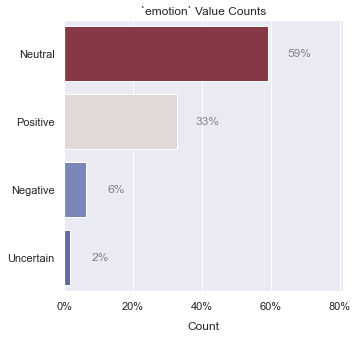

<IPython.core.display.Javascript object>

In [9]:
plotting.countplot(data=df["emotion"], normalize=True)

<AxesSubplot:title={'center':'`emotion` Value Counts'}, xlabel='Count'>

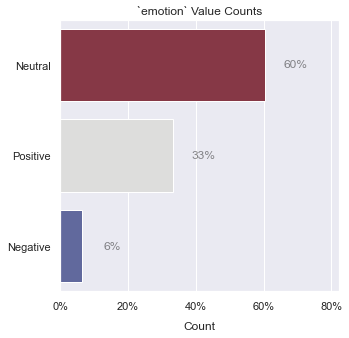

<IPython.core.display.Javascript object>

In [10]:
# Remove 'Uncertain' category
df.emotion.cat.remove_categories("Uncertain", inplace=True)
plotting.countplot(data=df.emotion, normalize=True)

## Missing Values

According to the table below, there are a lot of missing values in the 'object_of_emotion' category. I bet, however, that these NaN values correspond to the 'Neutral' category. If a tweet doesn't express a brand-emotion, then there shouldn't be any brand in the 'object_of_emotion' column.

There's also one null 'text' row, and a bunch of null 'emotion' rows where the 'Uncertain' category used to be.

In [11]:
cleaning.info(df)

,null,null_%,uniq,uniq_%,dup,dup_%
object_of_emotion,5802,63.81,9,0.10,22,0.24
emotion,156,1.72,3,0.03,22,0.24
text,1,0.01,9065,99.69,22,0.24


<IPython.core.display.Javascript object>

 I'll go ahead and drop the nulls in the 'text' and 'emotion' columns first.

In [12]:
df.dropna(subset=["text", "emotion"], inplace=True)
cleaning.info(df)

,null,null_%,uniq,uniq_%,dup,dup_%
object_of_emotion,5654,63.27,9,0.10,22,0.25
text,0,0.00,8909,99.70,22,0.25
emotion,0,0.00,3,0.03,22,0.25


<IPython.core.display.Javascript object>

In [14]:
null_rows = cleaning.null_rows(df)
lang.readable_sample(null_rows["text"], random_state=rando)

|      | text                                                                                                                                    |
|-----:|:----------------------------------------------------------------------------------------------------------------------------------------|
| 5140 | RT @mention @mention New iPad Apps For Speech Therapy And Communication Are Showcased At #SXSW Conference {link} #sxswi #hcsm #sxswh    |
|  509 | Please RT Follow the next big #college social network @mention chance to win an #iPad at 7,000 followers #socialmedia #SXSW             |
| 4916 | millions of iPhone cases at #SXSW trade show but can any of them double as shuffleboard wax sprinklers? I think not. #fail (CC @mention |
| 6384 | RT @mention not launching any products at #SXSW but we're doing plenty else.  {link}                                                    |
|  790 | Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw&quot;                                             |
| 8793 | Google giving Social another go? {link} Google Circles, let's see what the guys at #SXSW make of it                                     |
| 8452 | @mention The unofficial #SXSW torrents are a great way to hear what you can expect this year {link}                                     |
| 3645 | U gotta fight for yr right to party &amp; to privacy ACLU/google #sxsw #partylikeits1986                                                |
|   61 | #futuremf @mention {link} spec for recipes on the web, now in google search: {link}  #sxsw                                              |
| 4081 | Hope people ask the tough questions. RT @mention Reminder: Android and Chrome TTS talk @mention 1 PM today!  {link}  #sxsw              |

<IPython.core.display.Javascript object>

Looks like some of the NaN values don't line up with the 'Neutral' category.

In [15]:
emotion_without_object = null_rows.loc[null_rows.emotion != "Neutral"]

# Delete variable
del null_rows

display(emotion_without_object.head(), emotion_without_object.shape)

,text,object_of_emotion,emotion
46,Hand-Held ���Hobo�۪: Drafthouse launches ���Ho...,NaN,Positive
64,Again? RT @mention Line at the Apple store is ...,NaN,Negative
68,Boooo! RT @mention Flipboard is developing an ...,NaN,Negative
103,Know that &quot;dataviz&quot; translates to &q...,NaN,Negative
112,Spark for #android is up for a #teamandroid aw...,NaN,Positive


(357, 3)

<IPython.core.display.Javascript object>

In [16]:
# Create regex for finding each brand
re_apple = r"ipad\d?\s*app|ipad\d?|iphone\s*app|iphone|apple"
re_google = r"android\s*app|android|google"

# Find all brand/product name occurrences for each brand
findings = lang.locate_patterns(
    re_apple,
    re_google,
    docs=emotion_without_object["text"],
    exclusive=True,
    flags=re.I,
)

# Convert to lowercase
findings = findings.str.lower()

# View results
display(
    findings.value_counts(),
    findings.size,
)

google         122
ipad            98
apple           76
iphone          57
ipad2           26
android         19
iphone app       8
ipad app         4
android app      1
ipad1            1
Name: locate_patterns, dtype: int64

412

<IPython.core.display.Javascript object>

In [18]:
# Rename Apple apps to match categories defined previously
findings = findings.str.replace(
    r"ipad\s+app|iphone\s+app", "ios app", case=False, regex=True
)

# Fuzzy match with previously defined categories
findings = lang.fuzzy_match(findings, df["object_of_emotion"].cat.categories)

# View results
findings.sort_values("score")

,original,match,score
5401,ipad2,iPad,89
3179,ipad2,iPad,89
8149,ipad2,iPad,89
6309,ipad2,iPad,89
3710,ipad2,iPad,89
...,...,...,...
3224,ipad,iPad,100
3179,ipad,iPad,100
3134,google,Google,100
3055,ipad,iPad,100


<IPython.core.display.Javascript object>

In [19]:
# Define sort order, i.e. fill priority
order = [
    "iOS App",
    "Android App",
    "iPhone",
    "iPad",
    "Android",
    "Apple",
    "Google",
]

# Sort values in reverse order
utils.explicit_sort(
    findings,
    order=order,
    by="match",
    ascending=False,
    inplace=True,
)

# Fill in reverse, overwriting lower priority values
for i, brand in findings.match.items():
    df.at[i, "object_of_emotion"] = brand
df.loc[findings.index].sample(10, random_state=rando)

,text,object_of_emotion,emotion
8029,"Yeah I wasn't doing it, but I got couldn't res...",iPad,Positive
2753,I love the waves!!!!!! {link} iPad Webber #jap...,iPad,Positive
8973,Google guy at #sxsw talk is explaining how he ...,Google,Negative
1089,���@mention So @mention just spilled the beans...,iPhone,Positive
4674,Apple opening up temporary store in downtown A...,iPad,Positive
4536,Whoa - line for ipad2 is 3blks long!!! #apple ...,iPad,Positive
6078,RT @mention I'm debuting my new iPhone &amp; D...,iPhone,Positive
6710,RT @mention Temporary #apple store is def not ...,Apple,Positive
682,#technews iPad 2 Gets Temporary Apple Store fo...,iPad,Positive
5501,RT @mention At #sxsw even the cabbies are tech...,iPhone,Positive


<IPython.core.display.Javascript object>

In [20]:
# Get indices which were not filled
emotion_without_object.drop(findings.index, inplace=True)

# Drop unfilled observations
df.drop(emotion_without_object.index, inplace=True)

print(f"{emotion_without_object.shape[0]} observations dropped.")

del emotion_without_object

24 observations dropped.


<IPython.core.display.Javascript object>

In [21]:
object_without_emotion = df.loc[
    (df.emotion == "Neutral") & df.object_of_emotion.notnull()
]
display(object_without_emotion.head(), object_without_emotion.shape)

,text,object_of_emotion,emotion
63,#Smile RT @mention I think Apple's &quot;pop-u...,Apple,Neutral
265,The #SXSW Apple &quot;pop-up&quot; store was n...,Apple,Neutral
317,I arrived at #sxsw and my @mention issue hasn'...,iOS App,Neutral
558,haha. the google &quot;Party like it's 1986&qu...,Google,Neutral
588,Diller on Google TV: &quot;The first product w...,Other Google Product,Neutral


(91, 3)

<IPython.core.display.Javascript object>

Tweet 6517 seems clearly negative to me, and 7137 seems kind of sardonic. 2666 seems weakly positive. 8647, 5696, 7521, 668, and 265 don't seem to express an emotion toward a brand or product. Since most of them seem neutral to me, and that's consistent with their 'Neutral' label, I'm going to keep them that way.

In [23]:
lang.readable_sample(object_without_emotion["text"], random_state=rando)

|      | text                                                                                                                                              |
|-----:|:--------------------------------------------------------------------------------------------------------------------------------------------------|
|  668 | #sxsw guy in front of me at this panel has an ipad in an etch-a-sketch case...device of wondeR? #iusxsw                                           |
| 1628 | @mention @mention Similarily, Tweetcaster for Android lets you zip tweets w annoying hash tags, like #sxsw                                        |
| 1253 | Google vp to speak. The topic: 10 quick steps to owning everything in the world. #sxsw {link}                                                     |
| 2849 | Nice to see the speaker sneak in an irrelevant snarky comment about Apple. Class!  #sxsw #authenticationdesign                                    |
| 7658 | Score a free imo tshirt outside the SXSW Apple store today at 2:15 PM &amp; check out imo's app for the iPad 2  {link}  #sxsw #ipad2              |
| 4119 | From #Apple to Naomi Campbell: pop-up stores are all the rage: {link} #sxsw                                                                       |
| 5912 | RT @mention Google to launch new social network at SXSW? - CNET News {link} #sxsw                                                                 |
| 6082 | RT @mention I'm not really at #sxsw. Just messing with you. I'm making money instead. // I bet someone left the iPad queue                        |
| 6491 | RT @mention RT @mention &quot;IAVA wants to be the Google of nonprofits.&quot; / yes, we do b/c our #vets deserve nothing less! #sxsw #letshookup |
| 8902 | @mention Which is to say iPad is going to be ubiquitous a lot faster than anyone expected a year or even 6 mo. ago. #newsapps #sxsw               |

<IPython.core.display.Javascript object>

In [24]:
# Set object to null where emotion is neutral
df.loc[object_without_emotion.index, "object_of_emotion"] = np.nan

# Ensure that 'Neutral' rows line up with 'NaN' rows
(df["emotion"] == "Neutral").equals(df["object_of_emotion"].isnull())

True

<IPython.core.display.Javascript object>

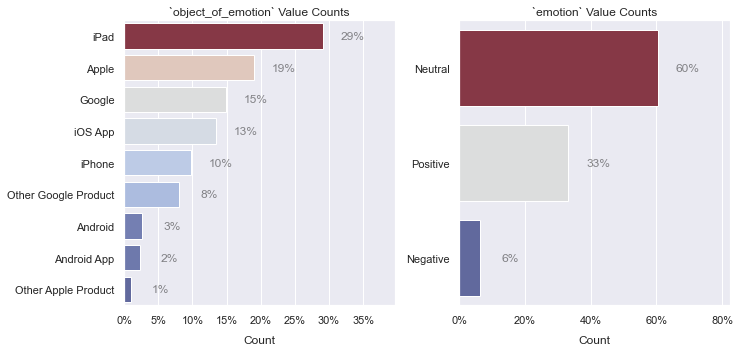

<IPython.core.display.Javascript object>

In [25]:
fig = plotting.multi_countplot(data=df.select_dtypes("category"), normalize=1)

There are $22$ duplicate rows, but I'm not going to remove them yet. I'll dynamically remove duplicates as part of my preprocessing pipeline so I can catch as many as possible.

In [26]:
cleaning.dup_rows(df).sort_values("text")

,text,object_of_emotion,emotion
3962,"#SXSW is just starting, #CTIA is around the co...",Android,Positive
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive
2559,Counting down the days to #sxsw plus strong Ca...,Apple,Positive
776,Google to Launch Major New Social Network Call...,NaN,Neutral
8483,I just noticed DST is coming this weekend. How...,iPhone,Negative
2232,Marissa Mayer: Google Will Connect the Digital...,NaN,Neutral
8747,Need to buy an iPad2 while I'm in Austin at #s...,iPad,Positive
4897,"Oh. My. God. The #SXSW app for iPad is pure, u...",iOS App,Positive
5884,RT @mention Google to Launch Major New Social ...,NaN,Neutral
5882,RT @mention Google to Launch Major New Social ...,NaN,Neutral


<IPython.core.display.Javascript object>

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from functools import partial
from tools.modeling.transformers import PandasWrapper
import nltk
from nltk.tokenize.casual import casual_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from tools.language import (
    lowercase,
    strip_short,
    strip_multiwhite,
    strip_numeric,
    strip_non_alphanum,
    split_alphanum,
    strip_punct,
    unidecode,
    stem_text,
)


funcs = [
    lowercase,
    strip_short,
    partial(strip_punct, exclude="@#"),
    strip_multiwhite,
    strip_numeric,
    strip_non_alphanum,
    split_alphanum,
    unidecode,
    stem_text,
]

func_names = utils.get_func_names(funcs)

func_names[3] = "strip_multiwhite"
func_names[7] = "unidecode"

funcs = [FunctionTransformer(func=x) for x in funcs]

funcs = [PandasWrapper(x) for x in funcs]
funcs = pd.Series(dict(zip(func_names, funcs)))
funcs

lowercase             PandasWrapper(transformer=FunctionTransformer(...
strip_short           PandasWrapper(transformer=FunctionTransformer(...
strip_punct           PandasWrapper(transformer=FunctionTransformer(...
strip_multiwhite      PandasWrapper(transformer=FunctionTransformer(...
strip_numeric         PandasWrapper(transformer=FunctionTransformer(...
strip_non_alphanum    PandasWrapper(transformer=FunctionTransformer(...
split_alphanum        PandasWrapper(transformer=FunctionTransformer(...
unidecode             PandasWrapper(transformer=FunctionTransformer(...
stem_text             PandasWrapper(transformer=FunctionTransformer(...
dtype: object

<IPython.core.display.Javascript object>

In [28]:
text_cleaner = [
    "lowercase",
    "unidecode",
    "strip_punct",
    "split_alphanum",
    "strip_short",
    #     "stem_text",
    "strip_multiwhite",
]

text_cleaner = list(zip(text_cleaner, funcs.loc[text_cleaner].to_list()))
text_cleaner = Pipeline(text_cleaner)
text_cleaner.fit_transform(df.text)

0       @wesley have iphone after hrs tweeting #rise a...
1       @jessedee know about @fludapp awesome ipad iph...
2       @swonderlin can not wait for #ipad also they s...
3       @sxsw hope this year festival isn crashy this ...
4       @sxtxstate great stuff fri #sxsw marissa mayer...
                              ...                        
9088                           ipad everywhere #sxsw link
9089    wave buzz @mention interrupt your regularly sc...
9090    google zeiger physician never reported potenti...
9091    some verizon iphone customers complained their...
9092       @mention google tests check offers@ #sxsw link
Name: text, Length: 8912, dtype: object

<IPython.core.display.Javascript object>

# Exploration

In [29]:
df["clean_text"] = text_cleaner.fit_transform(df.text)
df.head()

,text,object_of_emotion,emotion,clean_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,@wesley have iphone after hrs tweeting #rise a...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iOS App,Positive,@jessedee know about @fludapp awesome ipad iph...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,@swonderlin can not wait for #ipad also they s...
3,@sxsw I hope this year's festival isn't as cra...,iOS App,Negative,@sxsw hope this year festival isn crashy this ...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,@sxtxstate great stuff fri #sxsw marissa mayer...


<IPython.core.display.Javascript object>

In [34]:
# Try POS filtering
# Try tfidf vectorizing with just POS tags

<IPython.core.display.Javascript object>

In [35]:
from operator import itemgetter

tags = tagged.explode().map(itemgetter(1))
df["pos_tags"] = utils.implode(tags)
df.head()

,text,object_of_emotion,emotion,clean_text,pos_tags
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,@wesley have iphone after hrs tweeting #rise a...,"[NNS, VBP, VBN, IN, NN, VBG, NN, NN, VBD, JJ, ..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iOS App,Positive,@jessedee know about @fludapp awesome ipad iph...,"[NN, VBP, IN, NNP, JJ, NN, NN, NN, IN, PRP, JJ..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,@swonderlin can not wait for #ipad also they s...,"[NNS, MD, RB, VB, IN, NN, RB, PRP, MD, NN, PRP..."
3,@sxsw I hope this year's festival isn't as cra...,iOS App,Negative,@sxsw hope this year festival isn crashy this ...,"[RB, NN, DT, NN, NN, NN, NN, DT, NN, NN, NN, NN]"
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,@sxtxstate great stuff fri #sxsw marissa mayer...,"[JJ, JJ, NN, NN, NNP, NN, NN, NN, NN, RB, JJ, ..."


<IPython.core.display.Javascript object>

In [51]:
treebank = pd.Series(list(lang.TREEBANK_TAGS))
verb_pos = treebank.loc[treebank.str.startswith("V")].to_list()
df["verbs"] = lang.filter_pos(df.clean_text, include=verb_pos)
df.loc[:, ["verbs", "emotion"]]

,verbs,emotion
0,have iphone tweeting was #sxsw,Negative
1,know giving,Positive
2,wait,Positive
3,NaN,Negative
4,amp,Positive
...,...,...
9088,#sxsw,Positive
9089,interrupt scheduled,Neutral
9090,reported physicians operating,Neutral
9091,complained fell were attended,Neutral


<IPython.core.display.Javascript object>

In [220]:
from gensim.parsing.preprocessing import STOPWORDS

stop_words = list(STOPWORDS) + ["sxsw", "#sxsw", "quot", "link"]
stop_words.sort()
print(stop_words)

['#sxsw', 'a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'computer', 'con', 'could', 'couldnt', 'cry', 'de', 'describe', 'detail', 'did', 'didn', 'do', 'does', 'doesn', 'doing', 'don', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fifty', 'fill', 'find', 'fire', 'first', 'five', 'for', 'former', 'formerly', 'fort

<IPython.core.display.Javascript object>

In [69]:
emo_docs = (
    pd.Series(df.groupby("emotion").groups)
    .map(lambda x: df.loc[x, "clean_text"])
    .map(lambda x: " ".join(x))
)

emo_docs

Negative    @wesley have iphone after hrs tweeting #rise a...
Neutral     @teachntech new ipad apps for #speechtherapy a...
Positive    @jessedee know about @fludapp awesome ipad iph...
dtype: object

<IPython.core.display.Javascript object>

In [74]:
tfidf = TfidfVectorizer(
    tokenizer=partial(casual_tokenize, strip_handles=True, reduce_len=True),
    stop_words=stop_words,
    max_features=None,
    norm="l2",
)
emo_vecs = tfidf.fit_transform(emo_docs.values)
emo_vecs

<3x9190 sparse matrix of type '<class 'numpy.float64'>'
	with 13598 stored elements in Compressed Sparse Row format>

<IPython.core.display.Javascript object>

In [75]:
emo_vecs = lang.frame_doc_vecs(emo_vecs, tfidf.vocabulary_, emo_docs.index).T
emo_vecs.tail()

,Negative,Neutral,Positive
zone,0.003641,0.000814,0.000000
zoom,0.000000,0.000407,0.001336
zuckerberg,0.000000,0.001606,0.000000
zynga,0.000000,0.002142,0.000000
zzzs,0.004787,0.000000,0.000000


<IPython.core.display.Javascript object>

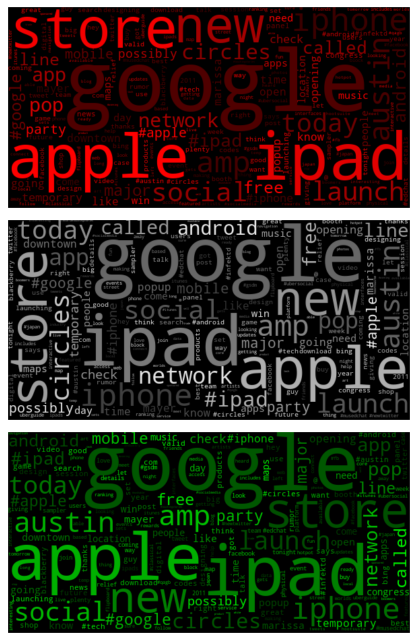

<IPython.core.display.Javascript object>

In [76]:
fig = plotting.emo_wordclouds(emo_vecs, orient="v", size=(6, 3))

In [83]:
emo_pos = (
    pd.Series(df.groupby("emotion").groups)
    .map(lambda x: df.loc[x, "pos_tags"])
    .map(lambda x: x.str.join(" "))
).str.join(" ")

emo_pos

Negative    NNS VBP VBN IN NN VBG NN NN VBD JJ NN JJ NN NN...
Neutral     JJ JJ NN NN IN NN CC NN VBP VBN DT NNP NN NN V...
Positive    NN VBP IN NNP JJ NN NN NN IN PRP JJ NN IN PRP$...
dtype: object

<IPython.core.display.Javascript object>

In [151]:
tfidf.set_params(
    tokenizer=None,
    lowercase=False,
    smooth_idf=False,
    stop_words=["NN", "JJ"],
)
emo_pos_vecs = tfidf.fit_transform(emo_pos.values)
emo_pos_vecs

<3x29 sparse matrix of type '<class 'numpy.float64'>'
	with 86 stored elements in Compressed Sparse Row format>

<IPython.core.display.Javascript object>

In [152]:
emo_pos_vecs = lang.frame_doc_vecs(emo_pos_vecs, tfidf.vocabulary_, emo_pos.index).T
emo_pos_vecs.tail()

,Negative,Neutral,Positive
VBP,0.334718,0.365632,0.330583
VBZ,0.164910,0.126798,0.142882
WDT,0.024492,0.011536,0.014153
WP,0.026124,0.035781,0.024431
WRB,0.057147,0.033337,0.027127


<IPython.core.display.Javascript object>

In [154]:
emo_pos_vecs.sort_values("Negative")

,Negative,Neutral,Positive
NNPS,0.000000,0.000687,0.000237
UH,0.000816,0.000587,0.000674
POS,0.000816,0.001466,0.001685
FW,0.003266,0.006355,0.006066
RBS,0.006531,0.003617,0.006403
PDT,0.010613,0.006257,0.007751
RBR,0.015511,0.009190,0.014322
EX,0.017144,0.007039,0.007751
JJR,0.019593,0.015544,0.017860
WDT,0.024492,0.011536,0.014153


<IPython.core.display.Javascript object>

<AxesSubplot:>

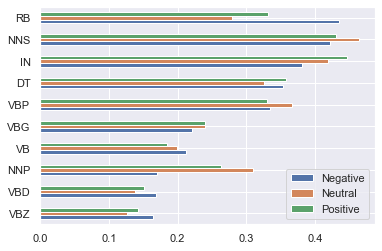

<IPython.core.display.Javascript object>

In [157]:
emo_pos_vecs.sort_values("Negative").tail(10).plot.barh()

In [162]:
df["RB"] = lang.filter_pos(df.clean_text, include=["RB"], as_tokens=True)
df.head()

,text,object_of_emotion,emotion,clean_text,pos_tags,verbs,WRB,RB
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,@wesley have iphone after hrs tweeting #rise a...,"[NNS, VBP, VBN, IN, NN, VBG, NN, NN, VBD, JJ, ...",have iphone tweeting was #sxsw,NaN,NaN
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iOS App,Positive,@jessedee know about @fludapp awesome ipad iph...,"[NN, VBP, IN, NNP, JJ, NN, NN, NN, IN, PRP, JJ...",know giving,NaN,[also]
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,@swonderlin can not wait for #ipad also they s...,"[NNS, MD, RB, VB, IN, NN, RB, PRP, MD, NN, PRP...",wait,NaN,"[not, also]"
3,@sxsw I hope this year's festival isn't as cra...,iOS App,Negative,@sxsw hope this year festival isn crashy this ...,"[RB, NN, DT, NN, NN, NN, NN, DT, NN, NN, NN, NN]",NaN,NaN,[@sxsw]
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,@sxtxstate great stuff fri #sxsw marissa mayer...,"[JJ, JJ, NN, NN, NNP, NN, NN, NN, NN, RB, JJ, ...",amp,NaN,[reilly]


<IPython.core.display.Javascript object>

In [164]:
lang.tokenize_tag(df.clean_text)

0       [(@wesley, NNS), (have, VBP), (iphone, VBN), (...
1       [(@jessedee, NN), (know, VBP), (about, IN), (@...
2       [(@swonderlin, NNS), (can, MD), (not, RB), (wa...
3       [(@sxsw, RB), (hope, NN), (this, DT), (year, N...
4       [(@sxtxstate, JJ), (great, JJ), (stuff, NN), (...
                              ...                        
9088    [(ipad, NN), (everywhere, RB), (#sxsw, VBZ), (...
9089    [(wave, NN), (buzz, NN), (@mention, NN), (inte...
9090    [(google, NN), (zeiger, NN), (physician, NN), ...
9091    [(some, DT), (verizon, NN), (iphone, NN), (cus...
9092    [(@mention, NN), (google, NN), (tests, NNS), (...
Name: clean_text, Length: 8912, dtype: object

<IPython.core.display.Javascript object>

<AxesSubplot:ylabel='RB,emotion'>

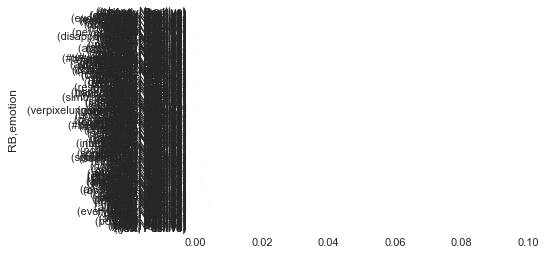

<IPython.core.display.Javascript object>

In [159]:
df[["RB", "emotion"]].loc[df.emotion != "Neutral"].dropna().explode("RB").value_counts(
    normalize=True
).plot.barh()

In [221]:
brand_docs = (
    pd.Series(df.groupby(["object_of_emotion", "emotion"]).groups)
    .map(lambda x: df.loc[x, "clean_text"])
    .map(lambda x: " ".join(x))
)

brand_docs = brand_docs.drop(index=np.nan, level=0)
brand_docs

Android               Negative    they took away the lego pit but replaced with ...
                      Positive    #sxsw just starting #ctia around the corner an...
Android App           Negative    beware the android #sxsw app for schedules com...
                      Positive    find amp start impromptu parties #sxsw with @h...
Apple                 Negative    again @mention line the apple store insane #sx...
                      Positive    counting down the days #sxsw plus strong canad...
Google                Negative    @mention false alarm google circles not coming...
                      Positive    @sxtxstate great stuff fri #sxsw marissa mayer...
Other Apple Product   Negative    @mention meant itunes doesn work for don run a...
                      Positive    pedicab iphone charger would epic win #sxsw pu...
Other Google Product  Negative    @mention google launch major new social networ...
                      Positive    gotta love this #sxsw google calendar feat

<IPython.core.display.Javascript object>

In [222]:
tfidf.set_params(
    lowercase=True,
    smooth_idf=True,
    stop_words=stop_words,
    tokenizer=partial(casual_tokenize, strip_handles=True, reduce_len=True),
)
brand_vecs = tfidf.fit_transform(brand_docs.values)
brand_vecs = lang.frame_doc_vecs(brand_vecs, tfidf.vocabulary_, brand_docs.index).T
brand_vecs

Android           Android App             Apple            Google  \
        Negative  Positive    Negative Positive Negative Positive Negative   
#            0.0  0.022343         0.0      0.0      0.0      0.0      0.0   
##sxsw       0.0  0.000000         0.0      0.0      0.0      0.0      0.0   
#10          0.0  0.000000         0.0      0.0      0.0      0.0      0.0   
#100         0.0  0.000000         0.0      0.0      0.0      0.0      0.0   
#106         0.0  0.000000         0.0      0.0      0.0      0.0      0.0   
...          ...       ...         ...      ...      ...      ...      ...   
zombies      0.0  0.000000         0.0      0.0      0.0      0.0      0.0   
zomg         0.0  0.000000         0.0      0.0      0.0      0.0      0.0   
zone         0.0  0.000000         0.0      0.0      0.0      0.0      0.0   
zoom         0.0  0.000000         0.0      0.0      0.0      0.0      0.0   
zzzs         0.0  0.000000         0.0      0.0      0.0      0.0      0.0   

                  Other Apple Product          Other Google Product            \
         Positive            Negative Positive             Negative  Positive   
#        0.000000                 0.0      0.0                  0.0  0.005612   
##sxsw   0.004208                 0.0      0.0                  0.0  0.000000   
#10      0.000000                 0.0      0.0                  0.0  0.000000   
#100     0.000000                 0.0      0.0                  0.0  0.000000   
#106     0.000000                 0.0      0.0                  0.0  0.000000   
...           ...                 ...      ...                  ...       ...   
zombies  0.003683                 0.0      0.0                  0.0  0.000000   
zomg     0.000000                 0.0      0.0                  0.0  0.000000   
zone     0.000000                 0.0      0.0                  0.0  0.000000   
zoom     0.003683                 0.0      0.0                  0.0  0.005612   
zzzs     0.000000                 0.0      0.0                  0.0  0.000000   

         iOS App              iPad             iPhone           
        Negative Positive Negative  Positive Negative Positive  
#            0.0      0.0  0.00000  0.000000  0.00000      0.0  
##sxsw       0.0      0.0  0.00000  0.000000  0.00000      0.0  
#10          0.0      0.0  0.00000  0.002530  0.00000      0.0  
#100         0.0      0.0  0.01375  0.000000  0.00000      0.0  
#106         0.0      0.0  0.00000  0.002530  0.00000      0.0  
...          ...      ...      ...       ...      ...      ...  
zombies      0.0      0.0  0.00000  0.002215  0.00000      0.0  
zomg         0.0      0.0  0.00000  0.015183  0.00000      0.0  
zone         0.0      0.0  0.01375  0.000000  0.00000      0.0  
zoom         0.0      0.0  0.00000  0.000000  0.00000      0.0  
zzzs         0.0      0.0  0.00000  0.000000  0.01974      0.0  

[5612 rows x 18 columns]

<IPython.core.display.Javascript object>

In [223]:
brand_vecs.columns = brand_vecs.columns.to_flat_index().str.join(" ")
brand_vecs

,Android Negative,Android Positive,Android App Negative,Android App Positive,Apple Negative,Apple Positive,Google Negative,Google Positive,Other Apple Product Negative,Other Apple Product Positive,Other Google Product Negative,Other Google Product Positive,iOS App Negative,iOS App Positive,iPad Negative,iPad Positive,iPhone Negative,iPhone Positive
#,0.0,0.022343,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.005612,0.0,0.0,0.00000,0.000000,0.00000,0.0
##sxsw,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.004208,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.00000,0.0
#10,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.002530,0.00000,0.0
#100,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.01375,0.000000,0.00000,0.0
#106,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.002530,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zombies,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.003683,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.002215,0.00000,0.0
zomg,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.015183,0.00000,0.0
zone,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.01375,0.000000,0.00000,0.0
zoom,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.003683,0.0,0.0,0.0,0.005612,0.0,0.0,0.00000,0.000000,0.00000,0.0


<IPython.core.display.Javascript object>

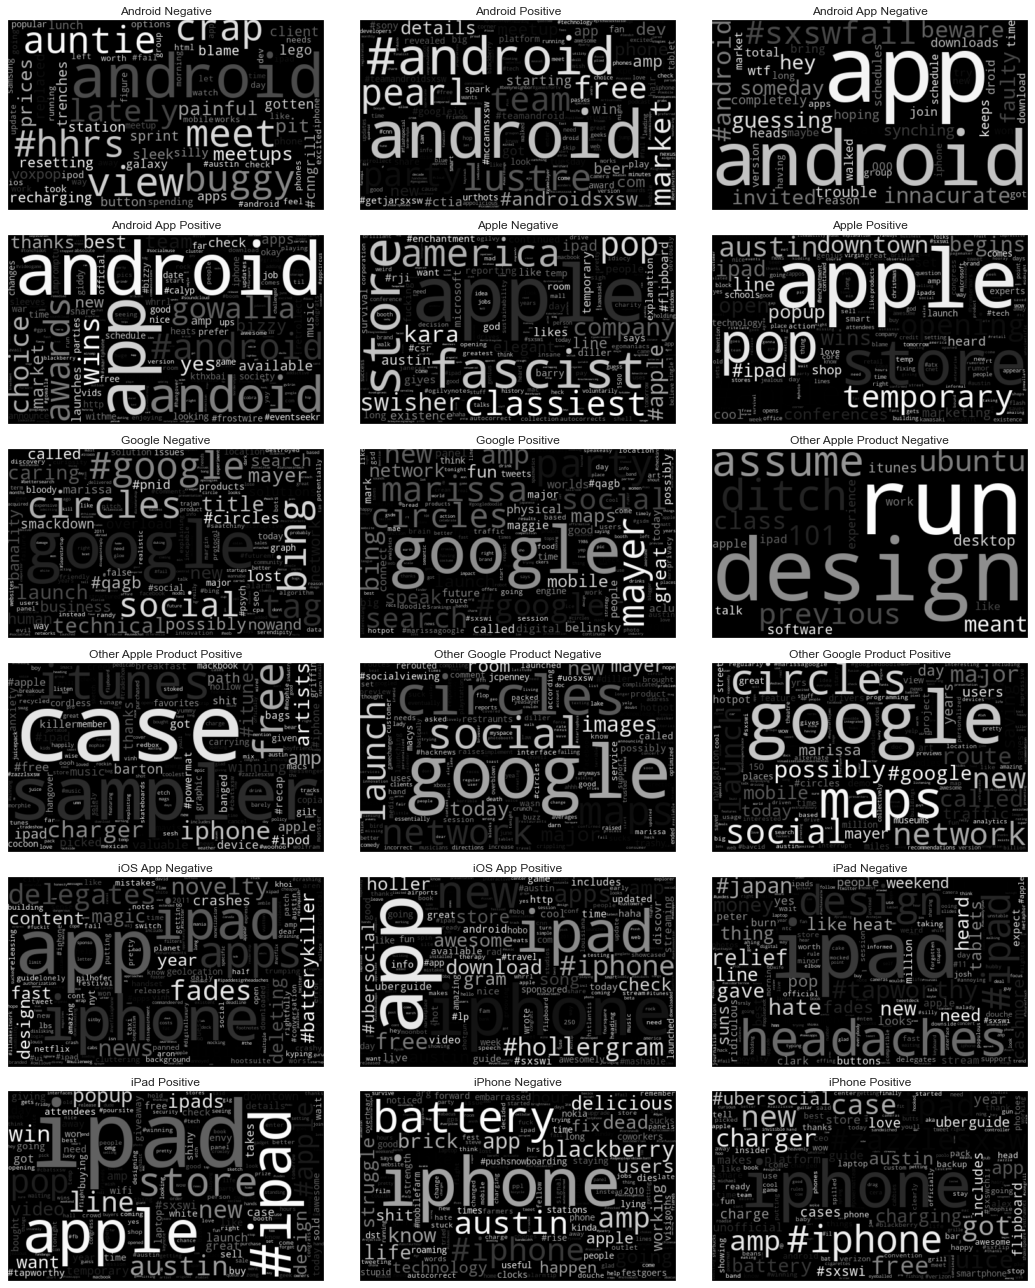

<IPython.core.display.Javascript object>

In [224]:
fig = plotting.multi_wordcloud(brand_vecs)

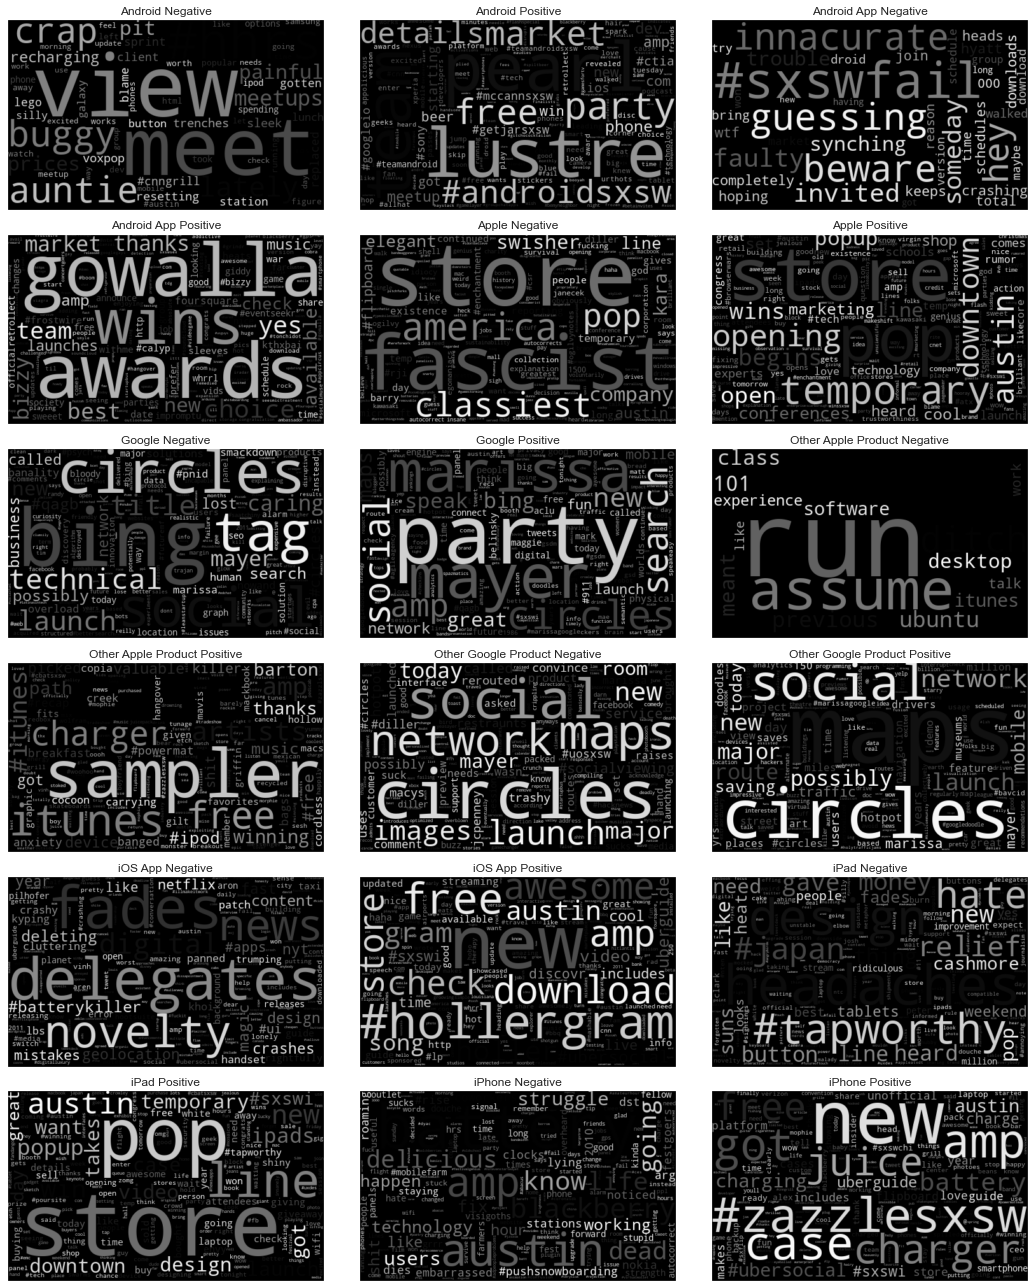

<IPython.core.display.Javascript object>

In [239]:
hide = [
    "iphone",
    "ipad",
    "google",
    "android",
    "apple",
    "app",
    "apps",
    "#apple",
    "#android",
    "#google",
    "#ipad",
    "#iphone",
    "andoid",
]
fig = plotting.multi_wordcloud(brand_vecs.drop(hide))